# **Classification of Cloud Coverage in Satellite Sentinel-3 OLCI Imagery and Sentinel-2 MSI Imagery**
GEOL0069 Artificial Intelligence for Earth Observation

Major Project 50%

Shannon James

# **Project Requirements**

1.   Google Earth Engine (https://earthengine.google.com/)

2.   Copernicus Dataspace (https://browser.dataspace.copernicus.eu/)

3.   IRIS Software (https://github.com/ESA-PhiLab/iris)

4.   Python Libraries: scikit-learn, numpy, matplotlib

# **Contents of this Notebook**

1.   Data Fetching & Pre-processing: Sentinel-2 MSI & Sentinel-3 OLCI

2.   Unsupervised Learning: GMM Clustering using Sentinel-3 Imagery

3.   Supervised Learning: IRIS Classification using Sentinel-3 Imagery

4.   Unsupervised Learning: GMM Clustering using Sentinel-2 Imagery

5.   Supervised Learning: IRIS Classification using Sentinel-2 Imagery





# **Data Fetching: Sentinal-2 OLCI & Sentinal-3 MSI**
First we fetch Sentinel-3 OLCI images from Copernicus Dataspace using Google Earth Engine (GEE). The code snippet involves fetching Sentinel-3 OLCI images based on the provided parameters: A mask line, representing a boundary around Chapel Hill and specifying a date range '2019-06-01' to '2019-06-02'.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from shapely.geometry import Polygon, Point
import ee
import requests
import pandas as pd
from datetime import datetime, timedelta
import subprocess

ee.Authenticate()
ee.Initialize(project = 'amiable-crane-412109')

# Essential Functions

In [ ]:
def parse_gee_filename(gee_filename):
    """
    Parses the Google Earth Engine filename to extract satellite name, sensing date, and start time.

    Parameters:
    gee_filename (str): Filename obtained from Google Earth Engine.

    Returns:
    tuple: Contains satellite name, sensing date, and start time.
    """
    parts = gee_filename.split('_')
    satellite = parts[0] + '_OL_1_EFR'
    start_datetime = parts[1]
    end_datetime = parts[2]

    # Extract date from the start_datetime (assuming the format is like '20180601T014926')
    sensing_date = start_datetime[:8]
    start_time = start_datetime[9:]

    return satellite, sensing_date, start_time

def get_access_token(username, password):
    """
    Retrieves access token from Copernicus Dataspace using the provided credentials.

    Parameters:
    username (str): Username for Copernicus Dataspace.
    password (str): Password for Copernicus Dataspace.

    Returns:
    str: Access token for authenticated sessions.
    """
    url = 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token'
    data = {
        'grant_type': 'password',
        'username': username,
        'password': password,
        'client_id': 'cdse-public'
    }
    response = requests.post(url, data=data)
    response.raise_for_status()
    return response.json()['access_token']

def query_sentinel3_olci_data(satellite, sensing_date, start_time, token):
    """
    Queries Sentinel-3 OLCI data from Copernicus Data Space based on satellite name, sensing date, and start time.

    Parameters:
    satellite (str): Name of the satellite.
    sensing_date (str): Date of the data sensing.
    start_time (str): Start time of the data sensing.
    token (str): Access token for authentication.

    Returns:
    DataFrame: A DataFrame containing the query results with details about the Sentinel-3 OLCI data.
    """
    # Convert sensing_date to datetime object and format it for the query
    sensing_datetime = datetime.strptime(f'{sensing_date}T{start_time}', '%Y%m%dT%H%M%S')
    sensing_datetime = sensing_datetime - timedelta(seconds=1)

    # Construct the request URL using the filter structure provided
    url = (
        f"https://catalogue.dataspace.copernicus.eu/odata/v1/Products?"
        f"$filter=contains(Name,'{satellite}') and "
        f"ContentDate/Start ge {sensing_datetime.strftime('%Y-%m-%dT%H:%M:%S.000Z')} and "
        f"ContentDate/Start le {(sensing_datetime + timedelta(days=1)).strftime('%Y-%m-%dT%H:%M:%S.000Z')}&"
        f"$orderby=ContentDate/Start&$top=1000"
    )
    headers = {'Authorization': f'Bearer {token}'}

    # Print the URL for debugging
    print(url)

    # Make the API request
    response = requests.get(url, headers=headers)
    # Check if the request was successful
    if response.status_code != 200:
        # Print error details and return an empty DataFrame if the request failed
        print(f"Error: Unable to fetch data. Status Code: {response.status_code}. Response: {response.text}")
        return pd.DataFrame()

    # Convert the JSON response to a DataFrame
    search_results_df = pd.DataFrame.from_dict(response.json()['value'])

    # Convert the 'ContentDate/Start' to datetime objects and sort the results
    search_results_df['SensingStart'] = pd.to_datetime(search_results_df['ContentDate'].apply(lambda x: x['Start']))
    search_results_df.sort_values(by='SensingStart', inplace=True)

    return search_results_df



def fetch_S3_images_by_area_and_date(date_range, spatial_extent, area_of_interest):
    """
    Fetches Sentinel-3 OLCI images based on a specified date range and area of interest.

    :param date_range: List containing the start and end dates (e.g., ['2018-06-01', '2018-06-02'])
    :param spatial_extent: List containing the spatial extent [min_lon, min_lat, max_lon, max_lat]
    :param area_of_interest: ee.Geometry object defining the specific area for which to fetch images

    :return: List of dictionaries, each containing details about a fetched image, including its ID, date, and download URL.
    """
    # Initialize the Earth Engine module
    ee.Initialize()

    # Define variables for Sentinel-3 OLCI query
    S3_product = 'COPERNICUS/S3/OLCI'

    # Query for Sentinel-3 data within the specified date range and area of interest
    S3_collection = ee.ImageCollection(S3_product) \
        .filterDate(date_range[0], date_range[1]) \
        .filterBounds(area_of_interest)

    # Convert S3_collection to a list of image IDs
    S3_image_ids = S3_collection.aggregate_array('system:index').getInfo()
    S3_images_info = S3_collection.getInfo()['features']

    # Initialize an empty list to store details
    S3_image_details = []

    # Iterate through each image in the collection
    for img_info in S3_images_info:
        # Fetch image ID
        image_id = img_info['id']

        # Fetch image date and other properties as needed
        image_date = img_info['properties']['system:time_start']  # Example property

        # Append the details to the list
        S3_image_details.append({
            'id': image_id,
            'date': image_date
        })

    return S3_image_details

def download_single_product(product_id, file_name, access_token, download_dir="downloaded_products"):
    """
    Download a single product from the Copernicus Data Space.

    :param product_id: The unique identifier for the product.
    :param file_name: The name of the file to be downloaded.
    :param access_token: The access token for authorization.
    :param download_dir: The directory where the product will be saved.
    """
    # Ensure the download directory exists
    os.makedirs(download_dir, exist_ok=True)

    # Construct the download URL
    url = f"https://zipper.dataspace.copernicus.eu/odata/v1/Products({product_id})/$value"

    # Set up the session and headers
    headers = {"Authorization": f"Bearer {access_token}"}
    session = requests.Session()
    session.headers.update(headers)

    # Perform the request
    response = session.get(url, headers=headers, stream=True)

    # Check if the request was successful
    if response.status_code == 200:
        # Define the path for the output file
        output_file_path = os.path.join(download_dir, file_name + ".zip")

        # Stream the content to a file
        with open(output_file_path, "wb") as file:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    file.write(chunk)
        print(f"Downloaded: {output_file_path}")
    else:
        print(f"Failed to download product {product_id}. Status Code: {response.status_code}")

def process_image_pair(s2_ee_image_id, token):
    """
    Processes a pair of Sentinel-2 images by querying the Copernicus Data Space to find the corresponding product name and ID.

    Parameters:
    s2_ee_image_id (str): The Sentinel-2 Earth Engine image ID.
    token (str): The access token for authenticating requests to the Copernicus Data Space.

    Returns:
    tuple: A tuple containing the product name and ID for the corresponding Sentinel-2 image.
    """
    sensing_start_date = s2_ee_image_id.split('_')[0]
    tile_number = s2_ee_image_id.split('_')[2]

    # Query the Copernicus Data Space
    df = query_sentinel2_data(sensing_start_date, tile_number, token)

    # Extract the correct MSIL1C product name
    return extract_correct_product_name(df, sensing_start_date, tile_number)

def get_s2_images_in_arctic(start_date, end_date, max_cloud_percentage=10):
    """
    Retrieves Sentinel-2 images within the Arctic region for a specified date range and cloud coverage limit.

    Parameters:
    start_date (str): The starting date for the image collection in 'YYYY-MM-DD' format.
    end_date (str): The ending date for the image collection in 'YYYY-MM-DD' format.
    area (ee.Geometry): The geographical area within which to filter the Sentinel-2 images.
    max_cloud_percentage (float, optional): The maximum cloud coverage percentage for filtering images.
                                            Defaults to 10 percent.

    Returns:
    ee.ImageCollection: A collection of Sentinel-2 images that fall within the specified date range,
                        cloud coverage limit, and geographical area.
    """
    # Define the Arctic region bounding box
    arctic_region = ee.Geometry.Rectangle([-180, 60, 180, 90])

    # Filter the Sentinel-2 collection
    s2_collection = ee.ImageCollection('COPERNICUS/S2') \
        .filterDate(start_date, end_date) \
        .filterBounds(arctic_region) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', max_cloud_percentage))

    return s2_collection

# Function to query Sentinel-2 data from Copernicus Data Space
def query_sentinel2_data(sensing_start_date, tile_number, token):
    """
    Queries the Sentinel-2 data from the Copernicus Data Space based on sensing start date, tile number, and access token.

    Parameters:
    sensing_start_date (str): The start date and time for the data sensing in the format 'YYYYMMDDTHHMMSS'.
    tile_number (str): The specific tile number of the Sentinel-2 data to be queried.
    token (str): The access token for authenticating requests to the Copernicus Data Space.

    Returns:
    DataFrame: A DataFrame containing the query results with details about the Sentinel-2 data.

    The function constructs a query URL with specified parameters, sends a request to the Copernicus Data Space,
    and returns the results as a DataFrame. It filters the data based on the tile number and the content start date
    within a certain time window.
    """
    # Convert sensing_start_date to datetime object and format it for the query
    start_time = datetime.strptime(sensing_start_date, '%Y%m%dT%H%M%S')
    end_time = start_time + timedelta(hours=2)  # Adjust the time window as necessary
    start_time_str = start_time.strftime('%Y-%m-%dT%H:%M:%SZ')
    end_time_str = end_time.strftime('%Y-%m-%dT%H:%M:%SZ')

    # Construct the request URL with the contains function for tile number
    url = f"https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$filter=contains(Name,'{tile_number}') and Collection/Name eq 'SENTINEL-2' and ContentDate/Start gt {start_time_str} and ContentDate/Start lt {end_time_str}"
    headers = {'Authorization': f'Bearer {token}'}

    # Make the API request
    response = requests.get(url, headers=headers)
    response.raise_for_status()

    return pd.DataFrame.from_dict(response.json()['value'])

def extract_correct_product_name(df, start_time, tile_number):
    """
    Extracts the correct product name and ID from a dataframe based on a specific start time and tile number.

    Parameters:
    df (DataFrame): The dataframe containing product information.
    start_time (str): The start time used to filter the products.
    tile_number (str): The tile number used to filter the products.

    Returns:
    tuple: A tuple containing the first matching product name and ID, or (None, None) if no match is found.
    """
    # Adjusted regex pattern to match the filename format
    pattern = f'MSIL1C.*{start_time}.*_{tile_number}_'
    filtered_products = df[df['Name'].str.contains(pattern, regex=True)]


    # Return the first matching product name, or None if not found
    return filtered_products['Name'].iloc[0] if not filtered_products.empty else None, filtered_products['Id'].iloc[0] if not filtered_products.empty else None

# Fethcing Sentinel-3 Data



In [ ]:
from shapely.geometry import Polygon
import ee

# Define Chapel Hill boundary coordinates
chapel_hill_boundary = [
    (-79.0136, 35.9796),  # Northeast corner
    (-79.0136, 35.8522),  # Southeast corner
    (-79.1070, 35.8522),  # Southwest corner
    (-79.1070, 35.9796),  # Northwest corner
    (-79.0136, 35.9796)   # Closing the polygon
]

# Create a Shapely Polygon object representing the Chapel Hill boundary
chapel_hill_polygon = Polygon(chapel_hill_boundary)

# Convert Chapel Hill boundary to Earth Engine Geometry
chapel_hill_geometry = ee.Geometry.Polygon(list(chapel_hill_boundary))

# Define date range and spatial extent
date_range = ['2019-06-01', '2019-06-02']
spatial_extent = [-180, 60, 180, 90]  # Example coordinates

# Fetch S3 images by area and date for Chapel Hill
export_tasks_chapel_hill = fetch_S3_images_by_area_and_date(date_range, spatial_extent, chapel_hill_geometry)

In [ ]:
for task in export_tasks_chapel_hill:
    print(task)

{'id': 'COPERNICUS/S3/OLCI/S3B_20190601T152420_20190601T152720', 'date': 1559402660000}


In [ ]:
# Example GEE image ID
gee_image_id = 'S3B_20190601T152420_20190601T152720' # replace with id printed above

# Parse the GEE filename to get the date and time
satellite, sensing_date, start_time = parse_gee_filename(gee_image_id)

# Get access token for Copernicus Data Space (ensure your credentials are correct)
username = 'shannonsjames24@gmail.com'
password = 'Games_Yes_2012'
token = get_access_token(username, password)

# Query the Copernicus Data Space for the corresponding Sentinel-3 OLCI data
s3_olci_data = query_sentinel3_olci_data(satellite, sensing_date, start_time, token)

# Print the results
print(s3_olci_data['Name'])

https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$filter=contains(Name,'S3B_OL_1_EFR') and ContentDate/Start ge 2019-06-01T15:24:19.000Z and ContentDate/Start le 2019-06-02T15:24:19.000Z&$orderby=ContentDate/Start&$top=1000
0      S3B_OL_1_EFR____20190601T152420_20190601T15272...
1      S3B_OL_1_EFR____20190601T152420_20190601T15272...
2      S3B_OL_1_EFR____20190601T152720_20190601T15302...
3      S3B_OL_1_EFR____20190601T152720_20190601T15302...
4      S3B_OL_1_EFR____20190601T153020_20190601T15332...
                             ...                        
461    S3B_OL_1_EFR____20190602T151609_20190602T15190...
462    S3B_OL_1_EFR____20190602T151909_20190602T15220...
463    S3B_OL_1_EFR____20190602T151909_20190602T15220...
464    S3B_OL_1_EFR____20190602T152209_20190602T15234...
465    S3B_OL_1_EFR____20190602T152209_20190602T15234...
Name: Name, Length: 466, dtype: object


In [ ]:
print(s3_olci_data['Name'][0])
print(s3_olci_data['Id'][0])
# S3B_OL_1_EFR____20190510T231025_20190510T231325_20190512T025627_0179_025_144_1800_LN1_O_NT_002.SEN3

S3B_OL_1_EFR____20190601T152420_20190601T152720_20200112T172819_0179_026_068_2340_MR1_R_NT_002.SEN3
dadcacfa-d221-58ff-838f-e099350931b4


In [ ]:
import os

username = 'shannonsjames24@gmail.com'
password = 'Games_Yes_2012'
token = get_access_token(username, password)
access_token = token  # Replace with your actual access token
download_dir = "/content/drive/MyDrive/Major_Project"  # Replace with your desired download directory
product_id = s3_olci_data['Id'][0]
file_name = s3_olci_data['Name'][0]
# Download the single product
download_single_product(product_id, file_name, access_token, download_dir)

Downloaded: /content/drive/MyDrive/Major_Project/S3A_OL_1_EFR____20190601T004604_20190601T004904_20190602T050958_0180_045_202_1800_LN1_O_NT_002.SEN3.zip


# Creating Sentinal-3 Image Chunks

The image extent that I have selected is too large to process, so here I create chunks of the images.

In [ ]:
!pip install netCDF4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.6 MB/s eta 0:00:00


In [ ]:
import os
import netCDF4
import numpy as np
import re

# Define the path to the main folder where your data is stored.
# You need to replace 'path/to/data' with the actual path to your data folder.
main_folder_path = '/content/drive/MyDrive/Major_Project/'

# This part of the code is responsible for finding all directories in the main_folder that end with '.SEN3'.
# '.SEN3' is the format of the folder containing specific satellite data files (in this case, OLCI data files).
directories = [d for d in os.listdir(main_folder_path) if os.path.isdir(os.path.join(main_folder_path, d)) and d.endswith('.SEN3')]

# Loop over each directory (i.e., each set of data) found above.
for directory in directories:
    # Construct the path to the OLCI data file within the directory.
    # This path is used to access the data files.
    OLCI_file_p = os.path.join(main_folder_path, directory)

    # Print the path to the current data file being processed.
    # This is helpful for tracking which file is being processed at any time.
    print(f"Processing: {OLCI_file_p}")

    # Load the instrument data from a file named 'instrument_data.nc' inside the directory.
    # This file contains various data about the instrument that captured the satellite data.
    instrument_data = netCDF4.Dataset(OLCI_file_p + '/instrument_data.nc')
    solar_flux = instrument_data.variables['solar_flux'][:]  # Extract the solar flux data.
    detector_index = instrument_data.variables['detector_index'][:]  # Extract the detector index.

    # Load tie geometries from a file named 'tie_geometries.nc'.
    # Tie geometries contain information about viewing angles, which are important for data analysis.
    tie_geometries = netCDF4.Dataset(OLCI_file_p + '/tie_geometries.nc')
    SZA = tie_geometries.variables['SZA'][:]  # Extract the Solar Zenith Angle (SZA).

    # Create a directory for saving the processed data using the original directory name.
    # This directory will be used to store output files.
    save_directory = os.path.join('/content/drive/MyDrive/Major_Project', directory)
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)

    # This loop processes each radiance band in the OLCI data.
    # OLCI instruments capture multiple bands, each representing different wavelengths.
    OLCI_data = []
    for Radiance in range(1, 22):  # There are 21 bands in OLCI data.

        Rstr = "%02d" % Radiance  # Formatting the band number.
        solar_flux_band = solar_flux[Radiance - 1]  # Get the solar flux for the current band.

        # Print information about the current band being processed.
        # This includes the band number and its corresponding solar flux.
        print(f"Processing Band: {Rstr}")
        print(f"Solar Flux for Band {Rstr}: {solar_flux_band}")

        # Load radiance values from the OLCI data file for the current band.
        OLCI_nc = netCDF4.Dataset(OLCI_file_p + '/Oa' + Rstr + '_radiance.nc')
        radiance_values = np.asarray(OLCI_nc['Oa' + Rstr + '_radiance'])

        # Initialize an array to store angle data, which will be calculated based on SZA.
        angle = np.zeros_like(radiance_values)
        for x in range(angle.shape[1]):
            angle[:, x] = SZA[:, int(x/64)]

        # Calculate the Top of Atmosphere Bidirectional Reflectance Factor (TOA BRF) for the current band.
        TOA_BRF = (np.pi * radiance_values) / (solar_flux_band[detector_index] * np.cos(np.radians(angle)))

        # Add the calculated TOA BRF data to the OLCI_data list.
        OLCI_data.append(TOA_BRF)

        # Print the range of reflectance values for the current band.
        print(f"Reflectance Values Range for Band {Rstr}: {np.nanmin(TOA_BRF)}, {np.nanmax(TOA_BRF)}")

    # Reshape the OLCI_data array for further analysis or visualization.
    reshaped_array = np.moveaxis(np.array(OLCI_data), 0, -1)
    print("Reshaped array shape:", reshaped_array.shape)
    # Save the reshaped array to the specified file path
    # Define the file path for saving the reshaped array
    save_filename = "reshaped_array.npy"  # Filename as a string
    # Combine the save directory and file name
    save_path = os.path.join(save_directory, save_filename)
    # Save the reshaped array to the specified file path
    np.save(save_path, reshaped_array)
    print("Reshaped array saved to:", save_path)

    # Split the reshaped array into smaller chunks along the second dimension.
    # This can be useful for handling large datasets more efficiently.
    split_arrays = np.array_split(reshaped_array, 5, axis=1)

    # Save each chunk of data separately.
    # This is helpful for processing or analyzing smaller portions of data at a time.
    for i, arr in enumerate(split_arrays):
        print(f"Chunk {i+1} shape:", arr.shape)
        save_path = os.path.join(save_directory, f"chunk_{i+1}_band_{Rstr}.npy")
        np.save(save_path, arr)
        print(f"Saved Chunk {i+1} for Band {Rstr} to {save_path}")

Processing: /content/drive/MyDrive/Major_Project/S3B_OL_1_EFR____20190601T152420_20190601T152720_20200112T172819_0179_026_068_2340_MR1_R_NT_002.SEN3
Processing Band: 01
Solar Flux for Band 01: [1512.8502 1512.7919 1512.7327 ... 1469.455  1469.4268 1469.3986]
Reflectance Values Range for Band 01: 0.09937720000743866, 169.7945098876953
Processing Band: 02
Solar Flux for Band 02: [1664.975  1664.9652 1664.9545 ... 1659.827  1659.8201 1659.8134]
Reflectance Values Range for Band 02: 0.08799120783805847, 150.31558227539062
Processing Band: 03
Solar Flux for Band 03: [1848.1083 1848.0684 1848.0284 ... 1830.5638 1830.5443 1830.5249]
Reflectance Values Range for Band 03: 0.0647306889295578, 136.2974090576172
Processing Band: 04
Solar Flux for Band 04: [1886.9711 1886.9469 1886.9235 ... 1877.1381 1877.1273 1877.1176]
Reflectance Values Range for Band 04: 0.04194939509034157, 132.91432189941406
Processing Band: 05
Solar Flux for Band 05: [1862.1501 1862.1715 1862.1929 ... 1872.4791 1872.4907 187

# Visualising Sentinel-3 Image
Here is a visulaisation of the chosen whole image and image chunks. For visualisation I have chosen Bands: 17, 5 and 2. These are the Red, Green, Blue (RGB) colour bands according to https://browser.dataspace.copernicus.eu/.

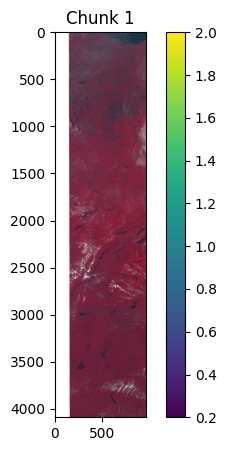

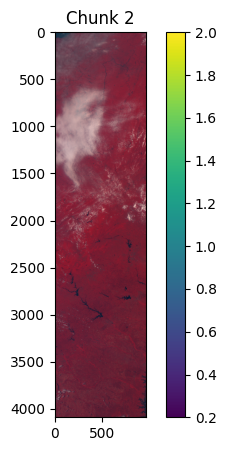

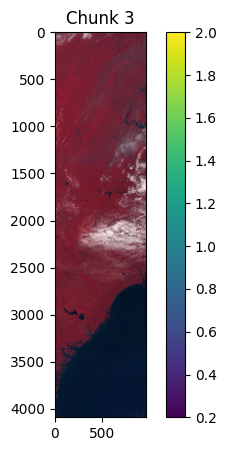

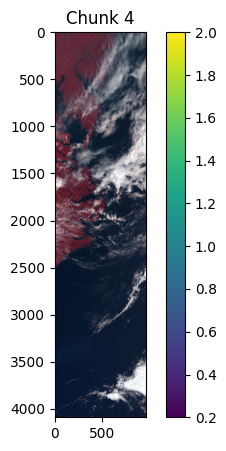

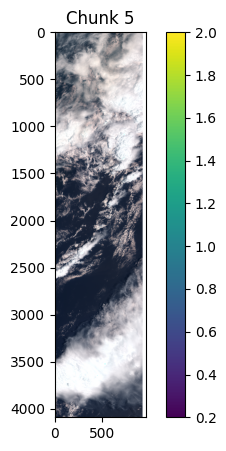

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Load each chunk and plot it
for i in range(1, 6):  # Assuming you have 5 chunks
    # Load the chunk
    chunk_path = f'/content/drive/MyDrive/Major_Project/S3B_OL_1_EFR____20190601T152420_20190601T152720_20200112T172819_0179_026_068_2340_MR1_R_NT_002.SEN3/chunk_{i}_band_21.npy'
    chunk_data = np.load(chunk_path)
    # Plot the chunk
    plt.figure(figsize=(5, 5))
    colors = [(0, 0, 1), (0, 0.5, 1), (1, 1, 1), (1, 0.5, 0), (1, 0, 0)]  # Blue to White to Orange
    cm = LinearSegmentedColormap.from_list('cloud_sea_ice_colormap', colors, N=256)
    plt.imshow(chunk_data[:, :, [16, 4, 1]], vmin=0.2, vmax=2)
    plt.title(f'Chunk {i}')
    plt.colorbar()
    plt.show()

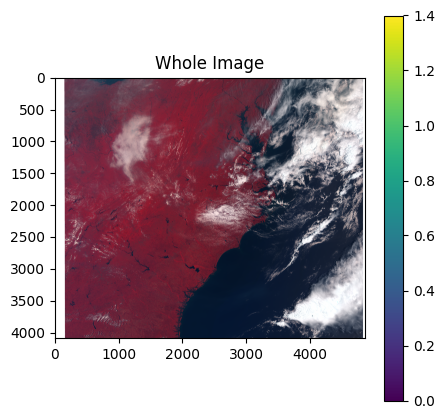

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# 'reshaped_array' contains image data as a numpy array with shape (4090, 4865, 21)
plt.figure(figsize=(5, 5))
reshaped_array_path = "/content/drive/MyDrive/Major_Project/S3B_OL_1_EFR____20190601T152420_20190601T152720_20200112T172819_0179_026_068_2340_MR1_R_NT_002.SEN3/reshaped_array.npy"
reshaped_array = np.load(reshaped_array_path)
plt.imshow(reshaped_array[:, :, [16, 4, 1]], vmin=0, vmax=1.4)
plt.title('Whole Image')
plt.colorbar()
plt.show()

In [ ]:
reshaped_array.shape

(4091, 4865, 21)

# Fetching Sentinel-2 Data

In [ ]:
import os

username = 'shannonsjames24@gmail.com'
password = 'Games_Yes_2012'
download_dir = "/content/drive/MyDrive/Major_Project"

# Get access token
token = get_access_token(username, password)

# GEE filename
gee_filename = '20190603T155829_N0207_R097_T17SPV_20190603T194426'

# Process image pair to get file name and product ID
file_name, product_id = process_image_pair(gee_filename, token)

# Download the product
# I download this directly from Copernicus dataspace as there is a mismatch...
# https://browser.dataspace.copernicus.eu/

# Print the file name of the downloaded product
print(file_name)

S2B_MSIL1C_20190603T155829_N0500_R097_T24XWN_20230604T221059.SAFE


# Visualising Sentinel-2 Image

In [ ]:
!pip install rasterio

In [ ]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from skimage import exposure
import numpy as np

# Define the paths to the bands in your downloaded Sentinel-2 data
base_path = "/content/drive/MyDrive/S2B_MSIL1C_20190603T155829_N0207_R097_T17SPV_20190603T194426.SAFE/GRANULE/L1C_T17SPV_A011706_20190603T160233/IMG_DATA/"
bands_paths = {
    'B2': base_path + 'T17SPV_20190603T155829_B02.jp2',
    'B3': base_path + 'T17SPV_20190603T155829_B03.jp2',
    'B4': base_path + 'T17SPV_20190603T155829_B04.jp2'
}

# Update the metadata to specify the number of bands
meta = rasterio.open(bands_paths['B2']).meta
meta.update({"count": 3})

# Define the path for the output RGB image
output_rgb_path = '/content/drive/MyDrive/Major_Project/RGB_image.tif'

# Write the bands to the RGB image
with rasterio.open(output_rgb_path, 'w', **meta) as dest:
    dest.write(rasterio.open(bands_paths['B2']).read(1), 1)
    dest.write(rasterio.open(bands_paths['B3']).read(1), 2)
    dest.write(rasterio.open(bands_paths['B4']).read(1), 3)

# Open the RGB image
img = rasterio.open(output_rgb_path)

image = np.array([img.read(3), img.read(2), img.read(1)])
image.shape

image = image.transpose(1,2,0)

p2, p98 = np.percentile(image, (2,98))
image = exposure.rescale_intensity(image, in_range=(p2, p98)) / 100000

# Define a plot
fig = plt.figure(figsize=(20,12))

# Show the figure
show(image.transpose(2,0,1), extent=[500000, 600000, 4200000, 4300000], transform=img.transform)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
image.shape

(10980, 10980, 3)

In [ ]:
import numpy as np

# Define the save path including the filename
save_path = '/content/drive/MyDrive/Major_Project/image_s2.npy'

# Save the image
np.save(save_path, image)

print("Image saved to:", save_path)

Image saved to: /content/drive/MyDrive/Major_Project/image_s2.npy


# **Unsupervised Learning: GMM Clustering using Sentinel-3 Imagery**

For this section, I use Gausian Mixture Model (GMM) to classify the ocean, land and clouds in the region of interest through a clustering technique.

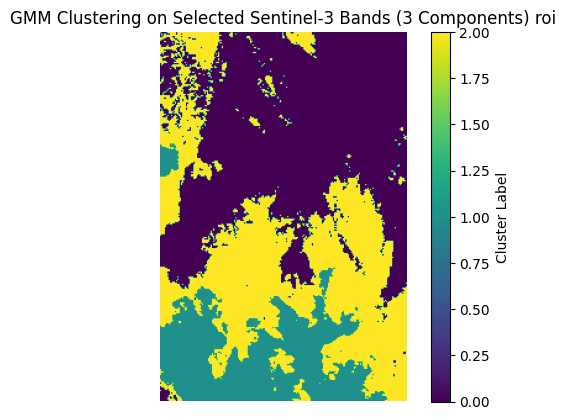

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# roi has dimensions (..., ..., 21)
# Select the desired bands: 16, 4, 1
selected_bands = roi[:, :, [16, 4, 1]]

# Create a mask for valid data (non-zero values in all selected bands)
valid_data_mask = np.all(selected_bands > 0, axis=2)

# Reshape for GMM, only including valid data
X = selected_bands[valid_data_mask].reshape((-1, 3))  # 3 bands selected

# GMM clustering with 3 components for land, ocean, and clouds
gmm = GaussianMixture(n_components=3, random_state=0).fit(X)
labels = gmm.predict(X)

# Create an empty array for the result, filled with a no-data value (e.g., -1)
labels_image = np.full(selected_bands.shape[:2], -1, dtype=int)

# Place GMM labels in the locations corresponding to valid data
labels_image[valid_data_mask] = labels

# Plotting the result
plt.imshow(labels_image, cmap='viridis')
plt.title('GMM Clustering on Selected Sentinel-3 Bands (3 Components) roi')
plt.colorbar(label='Cluster Label')
plt.axis('off')
plt.show()

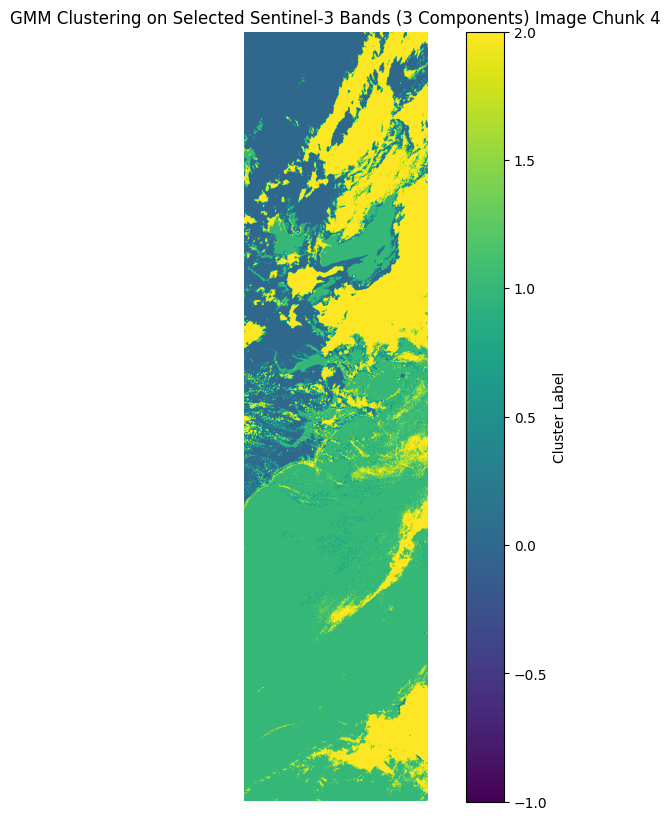

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# image has dimensions (4091, 4865, 21)
# Select the desired bands: 16, 4, 1
selected_bands = image[:,:, [16, 4, 1]]

# Create a mask for valid data (non-zero values in all selected bands)
valid_data_mask = np.all(selected_bands > 0, axis=2)

# Reshape for GMM, only including valid data
X = selected_bands[valid_data_mask].reshape((-1, 3))  # 3 bands selected

# GMM clustering with 3 components for land, ocean, and clouds
gmm = GaussianMixture(n_components=3, random_state=0).fit(X)
labels = gmm.predict(X)

# Create an empty array for the result, filled with a no-data value (e.g., -1)
labels_image = np.full(selected_bands.shape[:2], -1, dtype=int)

# Place GMM labels in the locations corresponding to valid data
labels_image[valid_data_mask] = labels

# Plotting the result
plt.figure(figsize=(10, 10))
plt.imshow(labels_image, cmap='viridis')
plt.title('GMM Clustering on Selected Sentinel-3 Bands (3 Components) Image Chunk 4')
plt.colorbar(label='Cluster Label')
plt.axis('off')
plt.show()

In [ ]:
unique, counts = np.unique(labels_image, return_counts=True)
class_counts = dict(zip(unique, counts))

print(class_counts)

{-1: 12, 0: 1085986, 1: 1782995, 2: 1111550}


# **Supervised Learning: IRIS Classification using Sentinal-3 Imagery**
For this section I have chosen to save chunk 4 for clouds classification in IRIS. The IRIS software is used seperately from this notebook.

In [ ]:
# Load chunk 4 as an image for IRIS
import numpy as np

chunk_path = '/content/drive/MyDrive/Major_Project/S3B_OL_1_EFR____20190601T152420_20190601T152720_20200112T172819_0179_026_068_2340_MR1_R_NT_002.SEN3/chunk_4_band_21.npy'

chunk_data = np.load(chunk_path)

image = chunk_data

# Loading Masks and Region of Interests
In IRIS I selected a smaller region of interest (roi) in the image, with boundary pixels of [100, 700, 300, 1000]. This is because manually classifying a smaller area of the image chunk is more efficient. In this smaller region of interest, I manulally classified cloud cover. We can load the mask I created and the region of interest to inspect if they are similar.

In [ ]:
# The images are in numpy array format
image = np.load('/content/drive/MyDrive/Major_Project/S3B_OL_1_EFR____20190601T152420_20190601T152720_20200112T172819_0179_026_068_2340_MR1_R_NT_002.SEN3' + '/chunk_4_band_21.npy')

# Mask

x1, y1, x2, y2 = [100, 700, 300, 1000]

# Extracting the region of interest (ROI) from the image

x1, y1, x2, y2 = [100, 700, 300, 1000]

roi = image[y1:y2, x1:x2]

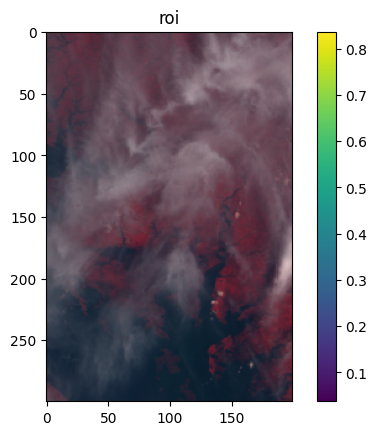

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

plt.imshow(roi[:, :, [16, 4, 1]]) # RGB bands
plt.title('roi')
plt.colorbar()
plt.show()

In [ ]:
import cv2

# Now also read in the mask file
mask = cv2.imread('/content/drive/MyDrive/Major_Project/mask.png', cv2.IMREAD_UNCHANGED)


# Because the mask file is in RGB which has 3 channels, so we should convert it into binary mask as array with only 0 and 1 values
binary_mask = np.where(mask[:,:,0] == 0, 1, 0)

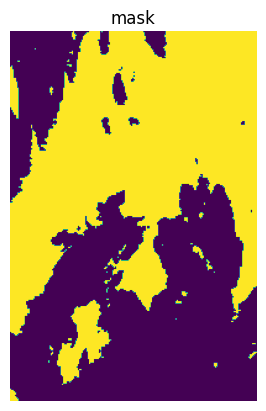

In [ ]:
# You can also plot the mask
plt.imshow(binary_mask)
plt.title('mask')
plt.axis('off')
plt.show()

# Rollout on Image Chunk: CNN
I have employed both supervised (IRIS) and unsupervised (Gaussian Mixture Model (GMM) clustering) methods to classify cloud cover in our region of interest.

To enable comparison, I will first apply the IRIS-classified cloud cover methodology to Image Chunk 4. This will involve using a Convolutional Neural Network (CNN) model to classify cloud cover. The CNN model will be trained using the manually classified pixels from the smaller region of interest.

In [ ]:
## check shapes are the same in the first two dimensions
print(binary_mask.shape)
print(roi.shape)

(300, 200)
(300, 200, 21)


In [ ]:
# roi is your data with shape (300, 200, 21)
patches = []

# Iterate over the height and width of the roi, excluding the border pixels
for i in range(1, roi.shape[0] - 1):
    for j in range(1, roi.shape[1] - 1):
        # Extract a (3, 3, 21) patch centered around the pixel (i, j)
        patch = roi[i-1:i+2, j-1:j+2, :]
        patches.append(patch)

# Convert the list of patches to a numpy array
patches_array = np.array(patches)

print(patches_array.shape)

(59004, 3, 3, 21)


In [ ]:
# Trim the mask to exclude boundary labels
trimmed_mask = binary_mask[1:-1, 1:-1]

# Flatten the trimmed mask to get a 1D array of labels
labels = trimmed_mask.flatten()

print(labels.shape)

(59004,)


In [ ]:
from sklearn.model_selection import train_test_split

# Assuming patches_array is your X and labels is your y
x_train, x_test, y_train, y_test = train_test_split(patches_array, labels, test_size=0.1, random_state=42)

In [ ]:
# Initially, we examine the quantity of each class present in the dataset
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))
# Identifying the class with the smaller count to balance the number in each class, for example, let it be 9396
num_class = 30432 # Adjust it to the amount you get

{0: 28572, 1: 30432}


In [ ]:
# Extract indices of both classes
indices_class_0 = np.where(labels == 0)[0]
indices_class_1 = np.where(labels == 1)[0]

# Randomly sample 9396 indices from class 0
sampled_indices_class_0 = np.random.choice(indices_class_0, num_class, replace=False)

# Combine the sampled indices with indices of class 1
combined_indices = np.concatenate([sampled_indices_class_0, indices_class_1])

# Extract the corresponding patches and labels
balanced_patches = patches_array[combined_indices]
balanced_labels = labels[combined_indices]


# Split the balanced dataset into training and testing sets with a 1:9 ratio
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(
    balanced_patches, balanced_labels, test_size=0.1, random_state=42
)

# Check the balance in y_train_balanced
unique, counts = np.unique(y_train_balanced, return_counts=True)
print(dict(zip(unique, counts)))

{0: 8412, 1: 27433}


In [ ]:
import os

save_path = '/content/drive/MyDrive/Major_Project'

np.save(os.path.join(save_path, 'X_train_balanced.npy'), X_train_balanced)
np.save(os.path.join(save_path, 'X_test_balanced.npy'), X_test_balanced)
np.save(os.path.join(save_path, 'y_train_balanced.npy'), y_train_balanced)
np.save(os.path.join(save_path, 'y_test_balanced.npy'), y_test_balanced)

In [ ]:
import os
X_train = np.load(os.path.join(save_path, 'X_train_balanced.npy'))
X_test = np.load(os.path.join(save_path, 'X_test_balanced.npy'))
y_train = np.load(os.path.join(save_path, 'y_train_balanced.npy'))
y_test = np.load(os.path.join(save_path, 'y_test_balanced.npy'))

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(3, 3, 21), padding='SAME'))
model.add(layers.MaxPooling2D((2, 2)))
# Add additional convolutional and pooling layers as needed
# ...

# Add dense layers for classification
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))  # 10 is the number of classes

# Compile and train the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, validation_split=0.1)

Epoch 1/10
1009/1009 [==============================] - 6s 5ms/step - loss: 0.1932 - accuracy: 0.9242 - val_loss: 0.0469 - val_accuracy: 0.9849
Epoch 2/10
1009/1009 [==============================] - 6s 6ms/step - loss: 0.0469 - accuracy: 0.9836 - val_loss: 0.0731 - val_accuracy: 0.9637
Epoch 3/10
1009/1009 [==============================] - 5s 5ms/step - loss: 0.0407 - accuracy: 0.9839 - val_loss: 0.0262 - val_accuracy: 0.9919
Epoch 4/10
1009/1009 [==============================] - 6s 6ms/step - loss: 0.0354 - accuracy: 0.9857 - val_loss: 0.0235 - val_accuracy: 0.9914
Epoch 5/10
1009/1009 [==============================] - 7s 7ms/step - loss: 0.0336 - accuracy: 0.9866 - val_loss: 0.0561 - val_accuracy: 0.9732
Epoch 6/10
1009/1009 [==============================] - 5s 5ms/step - loss: 0.0351 - accuracy: 0.9852 - val_loss: 0.0434 - val_accuracy: 0.9802
Epoch 7/10
1009/1009 [==============================] - 4s 4ms/step - loss: 0.0344 - accuracy: 0.9857 - val_loss: 0.0208 - val_accuracy:

In [ ]:
model.save('/content/drive/MyDrive/Major_Project/Model_CNN') # we save to make the process more efficient

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = tf.keras.models.load_model('/content/drive/MyDrive/Major_Project/Model_CNN')

In [ ]:
patches = []

# Iterate over the height and width of the roi, excluding the border pixels
for i in range(1, image.shape[0] - 1):
    for j in range(1, image.shape[1] - 1):
        # Extract a (3, 3, 21) patch centered around the pixel (i, j)
        patch = image[i-1:i+2, j-1:j+2, :]
        patches.append(patch)

# Convert the list of patches to a numpy array
x_test_all = np.array(patches)

y_pred=model.predict(x_test_all, batch_size = 250)
y_pred1 = np.argmax(y_pred,axis = 1)
map1 = y_pred1.reshape(image.shape[0] - 2, image.shape[1] - 2)

15882/15882 [==============================] - 28s 2ms/step


In [ ]:
import numpy as np

# Specify the directory path and filename
save_path = "/content/drive/MyDrive/Major_Project/map1.npy"

# Save the shape of map1 to the specified file path
np.save(save_path, map1)

(4089, 971)

In [ ]:
import numpy as np

map1 = np.load('/content/drive/MyDrive/Major_Project/map1.npy')

map1.shape

(4089, 971)

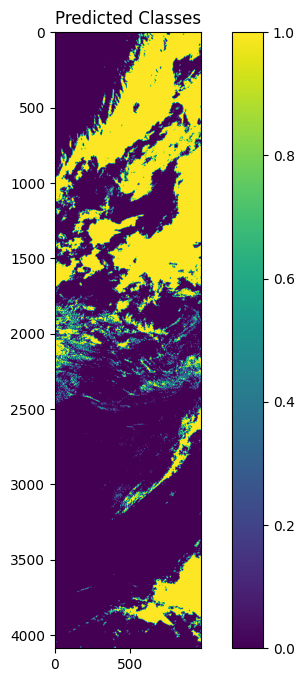

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axis object
plt.figure(figsize=(8, 8))
plt.imshow(map1, cmap='viridis')  # Adjust the colormap as needed
plt.colorbar()  # Add color bar
plt.title('Predicted Classes')
plt.grid(False)
plt.show()

# **Unsupervised Learning: GMM Clustering using Sentinel-2 Imagery**
In this section, we explore the use of unsupervised learning technique (GMM) for cloud detection in Sentinal-2 Imagery. Sentinal 2 imagery is higher resolution that Sentinal-3 and Senitnal-2 imagery is used in land-cover and land-use classification.

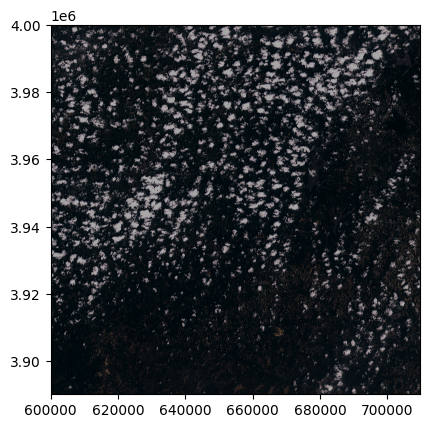

<Axes: >

In [ ]:
# The images are in numpy array format
image = np.load('/content/drive/MyDrive/Major_Project/image_s2.npy')

# Show the figure
show(image.transpose(2,0,1), extent=[500000, 600000, 4200000, 4300000], transform=img.transform)
plt.colorbar()

In [ ]:
image.shape

(10980, 10980, 3)

In [ ]:
# Mask

x1, y1, x2, y2 = [100, 700, 300, 1000]

# Extracting the region of interest (ROI) from the image

x1, y1, x2, y2 = [100, 700, 300, 1000]

roi = image[y1:y2, x1:x2]

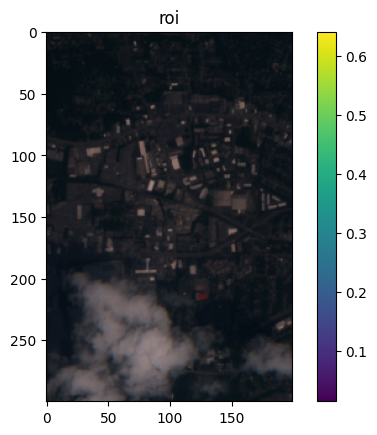

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

plt.imshow(roi[:, :, :]) # RGB bands
plt.title('roi')
plt.colorbar()
plt.show()

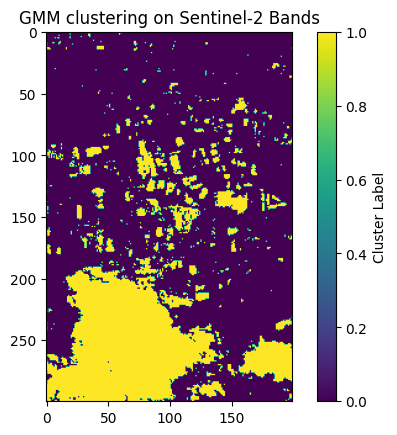

In [ ]:
# Import the GaussianMixture class
from sklearn.mixture import GaussianMixture

# Stack bands and create a mask for valid data (non-zero values in all bands)
band_stack = roi[:, :, :]
valid_data_mask = np.all(band_stack > 0, axis=2)

# Reshape for GMM, only including valid data
X = band_stack[valid_data_mask].reshape((-1, 3))

# GMM clustering
gmm = GaussianMixture(n_components=2, random_state=0).fit(X)
labels = gmm.predict(X)

# Create an empty array for the result, filled with a no-data value (e.g., -1)
labels_image = np.full(band_stack.shape[:2], -1, dtype=int)

# Place GMM labels in the locations corresponding to valid data
labels_image[valid_data_mask] = labels

# Plotting the result
plt.imshow(labels_image, cmap='viridis')
plt.title('GMM clustering on Sentinel-2 Bands')
plt.colorbar(label='Cluster Label')
plt.show()

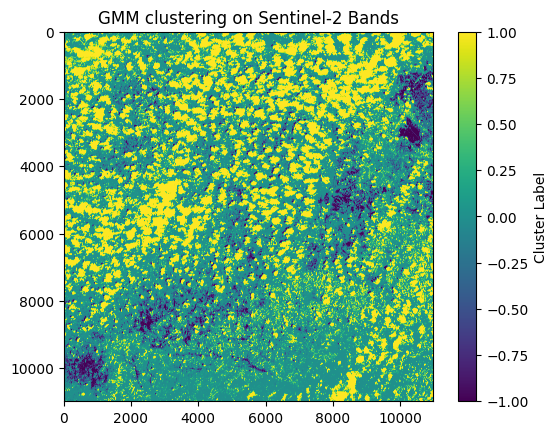

In [ ]:
# Stack bands and create a mask for valid data (non-zero values in all bands)
band_stack = image[:,:,:]
valid_data_mask = np.all(band_stack > 0, axis=2)

# Reshape for GMM, only including valid data
X = band_stack[valid_data_mask].reshape((-1, 3))

# GMM clustering
gmm = GaussianMixture(n_components=2, random_state=0).fit(X)
labels = gmm.predict(X)

# Create an empty array for the result, filled with a no-data value (e.g., -1)
labels_image = np.full(band_stack.shape[:2], -1, dtype=int)

# Place GMM labels in the locations corresponding to valid data
labels_image[valid_data_mask] = labels

# Plotting the result
plt.imshow(labels_image, cmap='viridis')
plt.title('GMM clustering on Sentinel-2 Bands')
plt.colorbar(label='Cluster Label')
plt.show()

In [ ]:
unique, counts = np.unique(labels_image, return_counts=True)
class_counts = dict(zip(unique, counts))

print(class_counts)

{-1: 7367530, 0: 73765218, 1: 39427652}


# **Supervised Learning: IRIS Classification using Sentinel-2 Imagery**

In [ ]:
s2_image = np.load('/content/drive/MyDrive/Major_Project/image_s2.npy')

# Calculate the number of chunks along each dimension
num_chunks_x = 1  # We'll keep it as 1 for now
num_chunks_y = 5  # We want 5 chunks along the y-axis

# Calculate the chunk size along the y-axis
chunk_size_y = s2_image.shape[1] // num_chunks_y

# Calculate the number of chunks along the x-axis based on the desired chunk size along the y-axis
num_chunks_x = (s2_image.shape[0] + chunk_size_y - 1) // chunk_size_y

# Adjust the chunk size along the x-axis to ensure a roughly equal number of chunks
chunk_size_x = s2_image.shape[0] // num_chunks_x

# Split the image into chunks
s2_image_chunks = []
for i in range(num_chunks_x):
    for j in range(num_chunks_y):
        start_x = i * chunk_size_x
        end_x = min((i + 1) * chunk_size_x, s2_image.shape[0])
        start_y = j * chunk_size_y
        end_y = min((j + 1) * chunk_size_y, s2_image.shape[1])
        chunk = s2_image[start_x:end_x, start_y:end_y]
        s2_image_chunks.append(chunk)

# Print out the number of chunks
print("Total number of chunks:", len(s2_image_chunks))

Total number of chunks: 25


In [ ]:
import os

# Directory to save the chunks
save_directory = "/content/drive/MyDrive/Major_Project/S2_Chunks"

# Create the directory if it doesn't exist
os.makedirs(save_directory, exist_ok=True)

# Save each chunk
for i, chunk in enumerate(s2_image_chunks):
    save_path = os.path.join(save_directory, f"chunk_{i+1}.npy")
    np.save(save_path, chunk)
    print(f"Saved Chunk {i+1} to {save_path}")

Saved Chunk 1 to /content/drive/MyDrive/Major_Project/S2_Chunks/chunk_1.npy
Saved Chunk 2 to /content/drive/MyDrive/Major_Project/S2_Chunks/chunk_2.npy
Saved Chunk 3 to /content/drive/MyDrive/Major_Project/S2_Chunks/chunk_3.npy
Saved Chunk 4 to /content/drive/MyDrive/Major_Project/S2_Chunks/chunk_4.npy
Saved Chunk 5 to /content/drive/MyDrive/Major_Project/S2_Chunks/chunk_5.npy
Saved Chunk 6 to /content/drive/MyDrive/Major_Project/S2_Chunks/chunk_6.npy
Saved Chunk 7 to /content/drive/MyDrive/Major_Project/S2_Chunks/chunk_7.npy
Saved Chunk 8 to /content/drive/MyDrive/Major_Project/S2_Chunks/chunk_8.npy
Saved Chunk 9 to /content/drive/MyDrive/Major_Project/S2_Chunks/chunk_9.npy
Saved Chunk 10 to /content/drive/MyDrive/Major_Project/S2_Chunks/chunk_10.npy
Saved Chunk 11 to /content/drive/MyDrive/Major_Project/S2_Chunks/chunk_11.npy
Saved Chunk 12 to /content/drive/MyDrive/Major_Project/S2_Chunks/chunk_12.npy
Saved Chunk 13 to /content/drive/MyDrive/Major_Project/S2_Chunks/chunk_13.npy
Save

In [ ]:
import numpy as np
import os

# Directory to save the chunks
save_directory = "/content/drive/MyDrive/Major_Project/S2_Chunks"

# Specify the index of the chunk to load (e.g., 1 for the first chunk)
chunk_index = 1

# Load the chunk
chunk_path = os.path.join(save_directory, f"chunk_{chunk_index}.npy")
loaded_chunk = np.load(chunk_path)

# Display information about the loaded chunk
print("Loaded chunk shape:", loaded_chunk.shape)

Loaded chunk shape: (2196, 2196, 3)


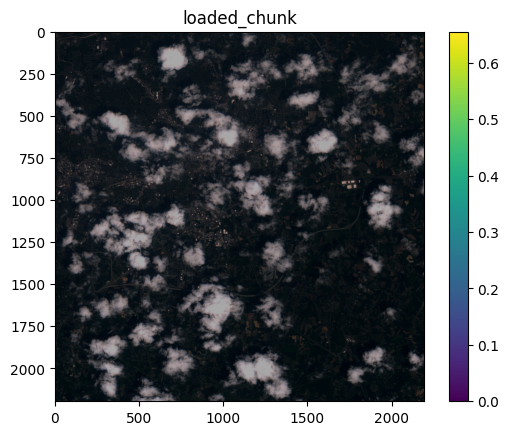

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

plt.imshow(loaded_chunk) # RGB bands
plt.title('loaded_chunk')
plt.colorbar()
plt.show()

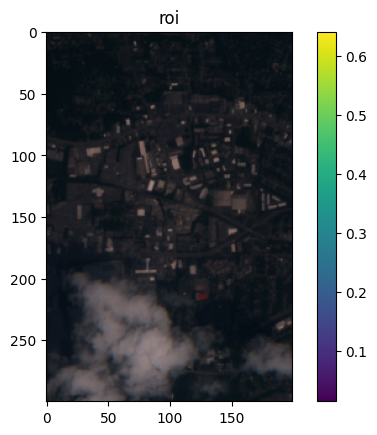

In [ ]:
# Extracting the region of interest (ROI) from the image

x1, y1, x2, y2 = [100, 700, 300, 1000]

roi = loaded_chunk[y1:y2, x1:x2]

plt.imshow(roi[:, :, :]) # RGB bands
plt.title('roi')
plt.colorbar()
plt.show()

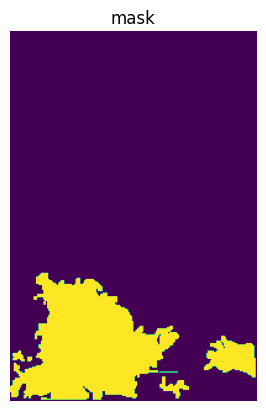

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Now also read in the mask file
S2_mask = cv2.imread('/content/drive/MyDrive/Major_Project/S2_mask.png', cv2.IMREAD_UNCHANGED)


# Because the mask file is in RGB which has 3 channels, so we should convert it into binary mask as array with only 0 and 1 values
binary_mask = np.where(S2_mask[:,:,0] == 0, 1, 0)

# You can also plot the mask
plt.imshow(binary_mask)
plt.title('mask')
plt.axis('off')
plt.show()

# Rollout on Image Chunk: CNN
I have employed both supervised (IRIS) and unsupervised (Gaussian Mixture Model (GMM) clustering) methods to classify cloud cover in our region of interest.

To enable comparison, I will first apply the IRIS-classified cloud cover methodology to Image Chunk 4. This will involve using a Convolutional Neural Network (CNN) model to classify cloud cover. The CNN model will be trained using the manually classified pixels from the smaller region of interest.

In [ ]:
## check shapes are the same in the first two dimensions
print(binary_mask.shape)
print(roi.shape)

(300, 200)
(300, 200, 3)


In [ ]:
# roi is your data with shape (300, 200, 3)
patches = []

# Iterate over the height and width of the roi, excluding the border pixels
for i in range(1, roi.shape[0] - 1):
    for j in range(1, roi.shape[1] - 1):
        # Extract a (3, 3, 21) patch centered around the pixel (i, j)
        patch = roi[i-1:i+2, j-1:j+2, :]
        patches.append(patch)

# Convert the list of patches to a numpy array
patches_array = np.array(patches)

print(patches_array.shape)

(59004, 3, 3, 3)


In [ ]:
# Trim the mask to exclude boundary labels
trimmed_mask = binary_mask[1:-1, 1:-1]

# Flatten the trimmed mask to get a 1D array of labels
labels = trimmed_mask.flatten()

print(labels.shape)

(59004,)


In [ ]:
from sklearn.model_selection import train_test_split

# Assuming patches_array is your X and labels is your y
x_train, x_test, y_train, y_test = train_test_split(patches_array, labels, test_size=0.1, random_state=42)

In [ ]:
# Initially, we examine the quantity of each class present in the dataset
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))
# Identifying the class with the smaller count to balance the number in each class, for example, let it be 9396
num_class = 9219 # Adjust it to the amount you get

# Extract indices of both classes
indices_class_0 = np.where(labels == 0)[0]
indices_class_1 = np.where(labels == 1)[0]

# Randomly sample 9396 indices from class 0
sampled_indices_class_0 = np.random.choice(indices_class_0, num_class, replace=False)

# Combine the sampled indices with indices of class 1
combined_indices = np.concatenate([sampled_indices_class_0, indices_class_1])

# Extract the corresponding patches and labels
balanced_patches = patches_array[combined_indices]
balanced_labels = labels[combined_indices]

{0: 49785, 1: 9219}


In [ ]:
# Split the balanced dataset into training and testing sets with a 1:9 ratio
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(
    balanced_patches, balanced_labels, test_size=0.1, random_state=42
)

# Check the balance in y_train_balanced
unique, counts = np.unique(y_train_balanced, return_counts=True)
print(dict(zip(unique, counts)))

{0: 8342, 1: 8252}


In [ ]:
import os

save_path = '/content/drive/MyDrive/Major_Project'

np.save(os.path.join(save_path, 'S2_X_train_balanced.npy'), X_train_balanced)
np.save(os.path.join(save_path, 'S2_X_test_balanced.npy'), X_test_balanced)
np.save(os.path.join(save_path, 'S2_y_train_balanced.npy'), y_train_balanced)
np.save(os.path.join(save_path, 'S2_y_test_balanced.npy'), y_test_balanced)

In [ ]:
import os
X_train = np.load(os.path.join(save_path, 'S2_X_train_balanced.npy'))
X_test = np.load(os.path.join(save_path, 'S2_X_test_balanced.npy'))
y_train = np.load(os.path.join(save_path, 'S2_y_train_balanced.npy'))
y_test = np.load(os.path.join(save_path, 'S2_y_test_balanced.npy'))

In [ ]:
X_train.shape
X_test.shape

(1844, 3, 3, 3)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(3, 3, 3), padding='SAME'))
model.add(layers.MaxPooling2D((2, 2)))
# Add additional convolutional and pooling layers as needed
# ...

# Add dense layers for classification
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))  # 10 is the number of classes

# Compile and train the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, validation_split=0.1)

Epoch 1/10
467/467 [==============================] - 2s 2ms/step - loss: 0.4753 - accuracy: 0.8153 - val_loss: 0.2452 - val_accuracy: 0.9145
Epoch 2/10
467/467 [==============================] - 1s 2ms/step - loss: 0.1917 - accuracy: 0.9250 - val_loss: 0.1926 - val_accuracy: 0.9265
Epoch 3/10
467/467 [==============================] - 1s 2ms/step - loss: 0.1671 - accuracy: 0.9348 - val_loss: 0.1621 - val_accuracy: 0.9392
Epoch 4/10
467/467 [==============================] - 1s 2ms/step - loss: 0.1371 - accuracy: 0.9485 - val_loss: 0.1387 - val_accuracy: 0.9476
Epoch 5/10
467/467 [==============================] - 1s 2ms/step - loss: 0.1160 - accuracy: 0.9565 - val_loss: 0.1153 - val_accuracy: 0.9566
Epoch 6/10
467/467 [==============================] - 1s 2ms/step - loss: 0.1059 - accuracy: 0.9609 - val_loss: 0.1045 - val_accuracy: 0.9620
Epoch 7/10
467/467 [==============================] - 1s 2ms/step - loss: 0.1015 - accuracy: 0.9626 - val_loss: 0.0998 - val_accuracy: 0.9639
Epoch 

In [ ]:
model.save('/content/drive/MyDrive/Major_Project/S2_Model_CNN') # we save to make the process more efficient

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = tf.keras.models.load_model('/content/drive/MyDrive/Major_Project/S2_Model_CNN')

In [ ]:
patches = []

# Iterate over the height and width of the roi, excluding the border pixels
for i in range(1, loaded_chunk.shape[0] - 1):
    for j in range(1, loaded_chunk.shape[1] - 1):
        # Extract a (3, 3, 21) patch centered around the pixel (i, j)
        patch = loaded_chunk[i-1:i+2, j-1:j+2, :]
        patches.append(patch)

# Convert the list of patches to a numpy array
x_test_all = np.array(patches)

y_pred=model.predict(x_test_all, batch_size = 250)
y_pred1 = np.argmax(y_pred,axis = 1)
map1 = y_pred1.reshape(loaded_chunk.shape[0] - 2, loaded_chunk.shape[1] - 2)

19255/19255 [==============================] - 34s 2ms/step


In [ ]:
import numpy as np

# Specify the directory path and filename
save_path = "/content/drive/MyDrive/Major_Project/S2_map1.npy"

# Save the shape of map1 to the specified file path
np.save(save_path, map1)

In [ ]:
import numpy as np

map1 = np.load('/content/drive/MyDrive/Major_Project/S2_map1.npy')

map1.shape

(2194, 2194)

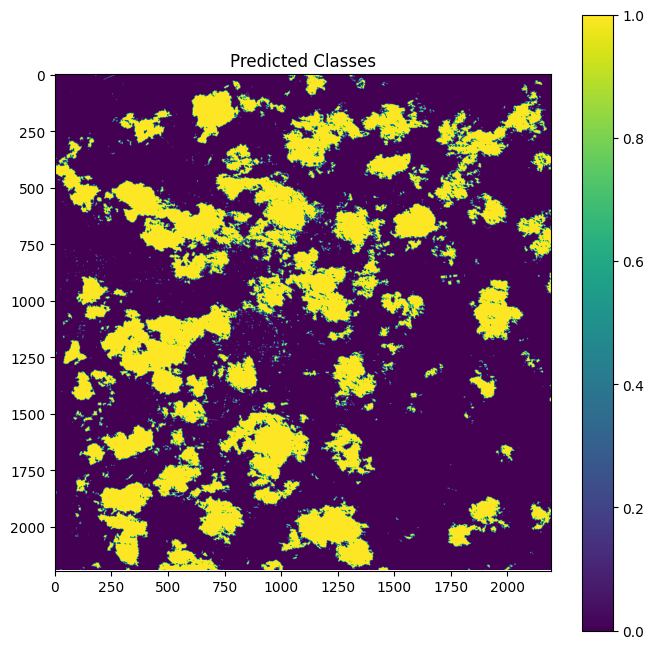

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axis object
plt.figure(figsize=(8, 8))
plt.imshow(map1, cmap='viridis')  # Adjust the colormap as needed
plt.colorbar()  # Add color bar
plt.title('Predicted Classes')
plt.grid(False)
plt.show()